## Capítulo 3: Clasificación


En el capítulo 1 se mencionó que las tareas de aprendizaje supervisado más comunes son la **regresión** (predicción de valores) y la **clasificación** (predicción de clases).

En el capítulo 2 se exploró una tarea de **regresión**, prediciendo los valores de la vivienda, usando algoritmos como la regresión lineal, Random Forest y árboles aleatorios.

En este capítulo nos centraremos en **SISTEMAS DE CLASIFICACIÓN**.

### MNIST

Vamos a usar el conjunto de datos de MNIST, que contiene 70 000 imágenes reducidas de dígitos escritas a mano.

Cada imágen está etiquetada con el código que representa.

Es el "hola mundo" del aprendizaje automático.

</br></br>
Vamos a usar la funcionalidad de Sklearn para descargar el conjunto de datos de MNIST de OpenML:

In [1]:
from sklearn.datasets import fetch_openml

mnist = fetch_openml('mnist_784', as_frame=False)

El paquete `sklear.datasets` contiene en su mayoría 3 tipos de funciones:

- Funciones `fetch_*`: Como `fetch_openml()` para descargar datasets de la vida real.

- Funciones `load_*` para cargar pequeños datasets de juguete.

- Funciones `make_*` para generar datasets falsos, prácticos para test.


Normalmente contienen los siguientes atributos:

* **"DESCR"**: Descripción del conjunto de datos.

* **"data"**: Datos de entrada en forma de matriz NumPy 2D.

* **"target"**: Etiquetas en forma de matriz NumPy 1D.


La función `fetch_openml()`, de forma predeterminada, retorna las entradas como Pandas DataFrame y las etiquetas como Pandas Series.

Pero el conjunto de datos de MNIST contiene imágenes y **los DataFrame no son buenos para eso**.

Es preferible configurar `as_frame=False` para tener los datos como matrices NumPy.

Veamos estas matrices:

In [2]:
X, y = mnist.data, mnist.target

In [3]:
X

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

In [4]:
X.shape

(70000, 784)

In [5]:
y

array(['5', '0', '4', ..., '4', '5', '6'], dtype=object)

In [6]:
y.shape

(70000,)

Hay 70.000 imágenes y cada una de ellas contiene **784** features.

Esto de debe a que cada imagen tiene una resolución de **28x28** píxeles y cada característica representa la intensidad del píxel de **0 (white) - 255 (black)**.

Tomemos una imagen del dataset.

Todo lo que tenemos que hacer es tomar el **vector de características de esa instancia** (imagen), redimensionarlo (`reshape`) a un array de 28x28 y mostrarlo por pantalla usando matplotlib con el ajuste de color `cmap="binary"` para obtener una escapa de grises conde el 0 es blanco y el 255 es negro.

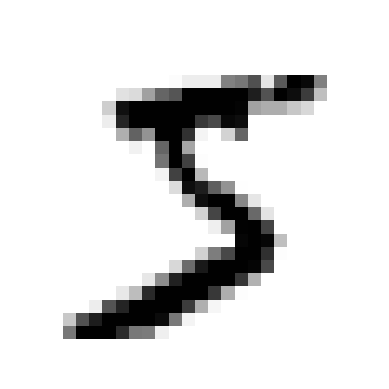

In [7]:
import matplotlib.pyplot as plt

def plot_digit(image_data):
    image = image_data.reshape(28, 28)
    plt.imshow(image, cmap="binary")
    plt.axis("off")
    
some_digit = X[0] # El primer elemento del dataset (número 5)
plot_digit(some_digit)
plt.show()

Si comprobamos su etiqueta, nos dice que efectivamente es un **5**.

In [8]:
y[0]

'5'

Normalmente separamos una pequeña parte del dataset y lo usamos para test antes de inspeccionar los elementos.

En este caso no es necesario porque la herramienta de `fetch_openml()` que estamos usando ya ha separado previamente los sets en **entrenamiento (primeras 60.000 imagenes)** y **test (10.000 imagenes)**.

In [9]:
X_train, X_test, y_train, y_test = X[:60000], X[60000:], y[:60000], y[60000:]

El conjunto de entrenamiento ya viene barajado para nosotros, lo cual garantiza que todos los pliegues de cross-validation serán similares (no queremos que a algún pliegue le falten dígitos).

Además, algunos algoritmos de aprendizaje automático son sensibles al orden de las instancias de entrenamiento y funcionan mal si ven muchas instancias similares seguidas (no randomizadas).

Hay que mezclar previamente el conjunto de datos.

![muestra](https://learning.oreilly.com/api/v2/epubs/urn:orm:book:9781098125967/files/assets/mls3_0302.png)

### Entrenando un clasificador binario

Vamos a simplificar el problema e **identificar sólo un dígito**, el número 5.

Esto es un "detector de 5" y se considera un *clasificador binario* que es capaz de distinguir entre dos clases:

* ES 5
* NO ES 5

Primero creamos los vectores de entrenamiento y test propios para este ejercicio:

In [10]:
# True si es 5 y False si no lo es

y_train_5 = (y_train == '5')
y_test_5 = (y_test == '5')

In [11]:
y_train_5

array([ True, False, False, ...,  True, False, False])

In [12]:
y_test_5

array([False, False, False, ..., False,  True, False])

Lo único que hemos cambiado es el vector de etiquetas, que en vez de tener 10 posibilidades, ahora tiene 2 (Sí, No).

Ahora vamos a tomar un clasificador y entrenarlo.

Una buena forma de empezar es usar el clasificador ***stochastic gradient descent*** (SGD) o descenso del gradiente estocástico.

Está dentro de la clase `SGDClassifier` de SKLearn.

Este clasificador es capaz de manejar datasets muy grandes de forma eficiente ya que toma las instancias de forma independiente (una por una) y hace que sea un **algoritmo muy conveniente para el aprendizaje online**.

In [13]:
# Creamos un SGDClassifier y lo entrenamos con todo el conjunto de entrenamiento

from sklearn.linear_model import SGDClassifier

sgd_clf = SGDClassifier(random_state=42)
sgd_clf.fit(X_train, y_train_5)

SGDClassifier(random_state=42)

Ahora podemos usarlo para detectar imágenes del número 5:

In [14]:
sgd_clf.predict([some_digit])

array([ True])

Nos da como resultado **True**, lo que significa que es un 5.


Una vez comprobado que funciona, vamos a evaluar el rendimiento.

### Medidas de rendimiento

**Evaluar un clasificador suele ser mas complejo que evaluar un regresor**.

Hay una gran cantidad de formas de medir el rendimiento así que prepara un café que empezamos.

### > Medición de la precisión mediante la validación cruzada

Una buena forma de evaluar el rendimiento es usar la validación cruzada como se hizo en el capítulo 2.

Usamos `cross_val_score()` para evaluar el SGDClassifier, usando la validación cruzada `k-fold` con 3 pliegues (folds).

* **RECUERDA**: La validación cruzada de K pliegues significa dividir el conjunto de entrenamiento en K pliegues (3 en este caso) y luego entrenar el modelo K veces, ofreciendo un pliegue diferente cada vez en la evaluación.

In [15]:
from sklearn.model_selection import cross_val_score

cross_val_score(sgd_clf, X_train, y_train_5, cv=3, scoring="accuracy")

array([0.95035, 0.96035, 0.9604 ])

Obtenemos una precisión por encima del 95% en todos los pliegues de validación.

Pero antes de cantar victoria vamos a usar un **clasificador ficticio** (Dummy Classifier) que solo clasifica cada imagen en la **clase más frecuente** (en este caso es la clase negativa *no 5*)

In [16]:
from sklearn.dummy import DummyClassifier

dummy_clf = DummyClassifier()
dummy_clf.fit(X_train, y_train)
print( any(dummy_clf.predict(X_train)) ) # Imprimir False: 5s no detectados

True


Averiguamos la nueva precisión del modelo:

In [17]:
cross_val_score(dummy_clf, X_train, y_train_5, cv=3, scoring="accuracy")

array([0.90965, 0.90965, 0.90965])

Tiene más del **90% de precisión!** 

Esto se debe a que solo hay alrededor de un 10% de imagenes con 5s, por lo que siempre adivines que una imagen no es un 5, tendrás razón el 90% de las veces.

Esto demuestra que la precisión generalmente no es la mejor medida para evaluar los clasificadores, especialmente cuando se trata de **conjuntos de datos sesgados** (cuando algunas clases son mucho más frecuentes que otras <hay más NO 5s que 5s>).

Otra forma mucho mejor de medir el rendimiento es mirar la **MATRIZ DE CONFUSIÓN** (CM).

---------------------------------------------------------------------

    IMPLEMENTACIÓN DE LA VALIDACIÓN CRUZADA (OPCIONAL)
    
    
Ocasionalmente vamos a necesitar tener más control sobre el proceso de validación cruzada del que SKlearn nos da.

En este caso podemos implementar el proceso de validación cruzada manualmente.

El siguiente código hace lo mismo que la función `cross_val_score()`:

In [18]:
## OPCIONAL

from sklearn.model_selection import StratifiedKFold
from sklearn.base import clone

skfolds = StratifiedKFold(n_splits=3)  # add shuffle=True if the dataset is
                                       # not already shuffled
for train_index, test_index in skfolds.split(X_train, y_train_5):
    clone_clf = clone(sgd_clf)
    X_train_folds = X_train[train_index]
    y_train_folds = y_train_5[train_index]
    X_test_fold = X_train[test_index]
    y_test_fold = y_train_5[test_index]

    clone_clf.fit(X_train_folds, y_train_folds)
    y_pred = clone_clf.predict(X_test_fold)
    n_correct = sum(y_pred == y_test_fold)
    print(n_correct / len(y_pred))  # prints 0.95035, 0.96035, and 0.9604

0.95035
0.96035
0.9604


La clase `StratifiedKFold` realiza un muestreo estratificado (como se explica en el capítulo 2) para producir pliegues (folds) que contienen una proporción representativa de cada clase.

El cada iteración, el código crea un clon del clasificador, entrena ese clon en los pliegues de entrenamiento y hace predicciones en el pliegue de prueba.

Luego cuenta el número de predicciones correctas y genera la proporción de predicciones correctas.

-----------------------------------------------------------------------

### > Matrices de confusión

La idea de una matriz de confusión es contar el número de veces que las instancias de clase A se clasifican como clase B, oara todos los pares A/B.

Por ejemplo, **para saber el número de veces que el clasificador confundió las imágenes  de 8 con 0, mirarías la fila número 8 y columna número 0 de la matriz de confusión**.

Para calcular la matriz de confusión necesitamos primero un conjunto de predicciones para poder compararlas con los objetivos reales.

Podríamos hacer predicciones en el conjunto de pruebas, pero lo mejor es no tocarlo por ahora (solo se toca al final).

In [19]:
from sklearn.model_selection import cross_val_predict

y_train_pred = cross_val_predict(sgd_clf, X_train, y_train_5, cv=3)

Al igual que la función `cross_val_score()`, `cross_val_predict()` realiza una validación cruzada de K veces pero en vez de retornar las puntuaciones de la evaluación, retorna las predicciones realizadas en cada prueba.

Significa que se obtiene una predicción limpia para instancia en el conjunto de entrenamiento ("limpio" = fuera de la muestra).

El modelo hace predicciones sobre unos datos que nunca vió durante el entrenamiento.

Finalmente obtenemos la matriz de confusión usando `confusion_matrix()`.

Se le pasan las clases objetivo (`y_train_`) y las predichas (`y_train_pred`).

In [20]:
from sklearn.metrics import confusion_matrix

cm = confusion_matrix(y_train_5, y_train_pred)

cm

array([[53892,   687],
       [ 1891,  3530]])

Matriz de confusión:

    FILA = Clase real
    COLUMNA = Clase predicha
    
* La primera fila de la matriz considera las imágenes que son NO-5s (clase negativa).

    * 53892 imágenes que no son NO-5s han sido clasificadas correctamente (**verdaderos negativos**).

    * 687 imágenes se clasificaron erróneamente como 5s (**falsos positivos**).

* La segunda fila de la matriz considera las imágenes que son 5s (clase positiva).

    * 1981 imágenes se clasificaron erróneamente como NO-5s (**falsos negativos**).

    * 3530 imágenes restantes se clasificaron correctamente como 5s (**verdaderos positivos**).


Un clasificador perfecto solo tendría verdaderos positivos y verdaderos negativos por lo que la matriz de confusión solo tendría valores distintos de 0 en su diagonal principal.

In [21]:
# (NO HACER) ASÍ DEBERÍA SER UNA MATRIZ PERFECTA

y_train_perfect_predictions = y_train_5  # pretendemos buscar la perfección

confusion_matrix(y_train_5, y_train_perfect_predictions)

array([[54579,     0],
       [    0,  5421]])

A pesar de que la matriz de confusión da mucha información, quizá nos interese más usar una **MÉTRICA MÁS PRECISA**.

Una interesante a tener en cuenta es la **precisión de las predicciones positivas**, a esto se le llama ***precisión*** del clasificador.

### Ecuación 3-1. Precisión

</br>

$precisión =  \frac{TP}{TP + FP}$

donde:

* $TP$ es el número de **verdaderos positivos**
* $FP$ el número de **falsos positivos**.

Una forma común de tener una precisión perfecta es crear un clasificador que siemrpe haga predicciones negativas, excepto por una sola predicción positiva en la instancia en la que tiene más confianza.

Si esta predicción es correcta, el clasificador tiene una precisión del 100% (precisión = 1/1 = 100%).

Obviamente el clasificador no sería muy útil ya que ignoraría todas las instancias positivas menos una.

Por lo tanto, la precisión se usa normalmente junto con otra métrica llamada *recuerdo*, tambien llamada *sensibilidad* o la *verdadera tasa positiva (TPR)*.

Esta es la proporción de instancias positivas que son detectadas correctamente por el clasificador.

### Ecuación 3-2. Recall (retirada)

</br>

$recall =  \frac{TP}{TP + FN}$

donde:
    
    FN es el número de falsos negativos
    
    
Si estás confundido con la matriz de confusión, esta imagen puede ayudar:

![recall](https://learning.oreilly.com/api/v2/epubs/urn:orm:book:9781098125967/files/assets/mls3_0303.png)

*Una matriz de confusión ilustrada que muestra ejemplos de verdaderos negativos (arriba a la izquierda), falsos positivos (arriba a la derecha), falsos negativos (abajo a la izquierda) y verdaderos positivos (abajo a la derecha)*

Video explicativo:

https://youtu.be/aR7eg_PrpJQ

### Precisión y Recall (Retirada)


SKlearn proporciona funciones para calcular las métricas del clasificador, incluyendo precisión y recall.

In [22]:
from sklearn.metrics import precision_score, recall_score

# precisión de las predicciones
precision_score(y_train_5, y_train_pred)  # == 3530 / (687 + 3530)

0.8370879772350012

In [23]:
# recall de las predicciones
recall_score(y_train_5, y_train_pred)  # == 3530 / (1891 + 3530)

0.6511713705958311

Ahora podemos ver que nuestro detector de 5s no es tan bueno como calculamos su precisión.

* Cuando afirma que una imagen es un 5: Es correcto solo el **83.7%** de las veces.

* Solo detecta el **65.1%** de los 5s que se le dan.

Es conveniente combinar la precisión y el recall en una sola métrica llamada **puntuación F1**, especialmente cuando se necesita **una sola métrica para comparar** dos clasificadores.


* **F1** es la **media armónica** de precisión y recall.

La media de toda la vida trata a todos los valores por igual mientras que la armónica da mucho más peso a los valores bajos.

**Esto hace que el clasificador solo obtenga una alta puntuación de F1 si tanto el recall como la precisión (ambos) son altos**.

### Ecuación 3-3. Puntuación de F1 (F1 score)
</br>

$F1 =  \frac{2}{ \frac{1}{precision} + \frac{1}{recall} } = 2 x \frac{precision x recall}{precision x recall} = \frac{TP}{TP + \frac{FN+FP}{2}}$

Para calcular la puntuación de F1, se llama a la función `f1_score()`:

In [24]:
from sklearn.metrics import f1_score

f1_score(y_train_5, y_train_pred)

0.7325171197343846

F1 score **favorece a los clasificadores que tienen una precisión y recall similares**.

No siempre necesitamos esto: En algunos contextos nos importa principalmente la precisión, y en otros contextos realmente importa el racall.

Por ejemlplo:

Si se entrenó un clasificador para **detectar videos que son seguros para niños**, probablemente prefiramos un clasificador que rechace muchos vídeos buenos (bajo reacall) pero que los mantenga seguros (alta precisión), en lugar de un clasificador que tenga un recall mucho más alto pero que permita que aparezcan videos realmente malos en nuestras predicciones (en ese caso).

Por otro lado:

Supongamos que entrenamos un clasificador para **detectar a los ladrones de tiendas en las imagenes de vigilancia**: 
Probablemente esté bien si nuestro clasificador solo tiene un 30% de precisión, siempre y cuando tenga un 99% de recall (seguramente algunos guardias de seguridad recibirán alertas falsas, pero casi todos los ladrones serán atrapados.

Desafortunadamente **NO** puedes tenerlo en ambos sentidos:

**Aumentar la precisión reduce el recall y viceversa (*compensación de precisión/recall*)**.

### Compensación precisión/recall

Veamos como `SGDClassifier` toma sus decisiones para la clasificación.

Para cada instancia calcula una puntuación basada en una **función de decisión**.

Si esta puntuación es mayor que el umbral, asigna la instancia a la clase positiva.

En caso contrario asigna la instancia a la clase negativa.

En la imágen inferior podemos dígitos que se esparcen desde la puntuación más baja (izquierda) hasta la más alta (derecha).

Supongamos que el umbral de decisión se coloca en la parte central (entre ambos 5s), tendremos:

* **4 positivos verdaderos (5 reales) a la derecha de ese umbral.**
* **1 falso positivo (realmente, un 6).**

Por lo tanto, con ese umbral, la precisión es del 80% (4 de 5).
Pero de los 6,5 reales, el clasificador solo detecta 4, por lo que el recall es del 67% (4 de 6).

Si subimos el umbral (movemos hacia la derecha), el falso positivo (el 6) se convierte en un verdadero negativo, aumentando así la precisión (hasta el 100% en este caso), pero un verdadero positivo se convierte en un falso negativo, disminuyendo el recall hasta un 50%.

Por el contrario, bajar el umbral aumenta el recall y reduce la precisión.

![precision_recall](https://learning.oreilly.com/api/v2/epubs/urn:orm:book:9781098125967/files/assets/mls3_0304.png)

*La compensación de precisión/retirada: las imágenes se clasifican por su puntuación de clasificador, y las que están por encima del umbral de decisión elegido se consideran positivas; cuanto mayor sea el umbral, menor será la retirada, pero (en general) mayor será la precisión*

-----------------------------------------------------------------------

Sk-Learn no permite establecer el umbral directamente pero tenemos acceso a las puntuaciones de decisión que usa para hacer las predicciones.

En vez de llamar al método `predict()` del clasificador, podemos llamar al objeto `decision_function()`, que retorna la puntuación para cada instancia y después usar cualquier umbral que queramos para hacer las predicciones basadas en esas puntuaciones.

In [26]:
y_scores = sgd_clf.decision_function([some_digit])
y_scores

array([2164.22030239])

In [28]:
threshold = 0 # umbral
y_some_digit_pred = (y_scores > threshold)
y_some_digit_pred

array([ True])

El `SGDClassifier` usa un umbral igual a 0, entonces el siguiente código retorna el mismo resultado que el método `predict()` (ej: True).

Vamos a aumentar el umbral:

In [29]:
threshold = 3000
y_some_digit_pred = (y_scores > threshold)
y_some_digit_pred

array([False])

Esto confirma que **el aumento del umbral disminuye el recuerdo**.

La imagen en realidad representa un 5 y elclasificador la detecta cuando el umbral es 0, pero no lo hace cuadno el umbral aumenta a 3000.

**Cómo decidimos que umbral usar?**

